
# Projeto: Predição e Insights de Filmes — *The Movies Dataset*

**Disciplina:** Fundamentos de Big Data  
**Notebook:** Pipeline completo (bronze → silver → gold), EDA e baseline de modelagem  
**Base:** `movies_metadata.csv` (Kaggle — The Movies Dataset)  



## Objetivos
- Montar um **pipeline de dados** de ponta a ponta cobrindo **Ingestão**, **Transformação**, **Carregamento** e **Destino**.
- Padronizar o schema do `movies_metadata.csv`, tratar erros e enriquecer com colunas derivadas.
- Entregar **arquivos Parquet** nas camadas **/bronze**, **/silver** e **/gold**.
- Realizar **EDA** enxuta e **modelagem baseline** (prever `vote_average` ou `revenue`).
- Salvar **insumos finais** (tabelas e gráficos) para consumo.



## Estrutura de Projeto (sugerida para o repositório)
```
/codigo               # scripts python e notebooks (.ipynb)
/notebooks            # notebooks intermediários (opcional)
/documentacao         # diagrama de arquitetura, PDFs, etc.
/dados
  /raw                # arquivos originais (não versionar grandes)
  /bronze             # parquet/CSV bruto padronizado
  /silver             # parquet já limpo/enriquecido
  /gold               # datasets finais prontos para análise/modelo
README.md
```



## 0. Setup
Execute para instalar/carregar dependências no Colab.


In [1]:
# Se estiver no Colab, descomente para instalar libs extras (se necessário):
# !pip install pyarrow fastparquet scikit-learn pandas numpy matplotlib seaborn

import os
import json
import ast
import math
import pandas as pd
import numpy as np
import kaggle
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = Path.cwd() / "../dados"
RAW_DIR = BASE_DIR / "raw"
BRONZE_DIR = BASE_DIR / "bronze"
SILVER_DIR = BASE_DIR / "silver"
GOLD_DIR = BASE_DIR / "gold"

for d in [RAW_DIR, BRONZE_DIR, SILVER_DIR, GOLD_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Estrutura criada em:", BASE_DIR.resolve())

Estrutura criada em: /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/dados


## 1. Ingestão (batch)
Escolha uma das opções abaixo:
1. **Upload direto** do arquivo `movies_metadata.csv` para a pasta `/dados/raw`.
2. **Google Drive**: montar Drive e copiar o CSV para `/dados/raw`.
3. **API do Kaggle** (no Colab): configurar `kaggle.json` e baixar o dataset (opcional).

> **Nota:** Este notebook assume **execução em batch** (lotes). Para simular **streaming**, ver a seção opcional ao final.

In [2]:

# Configurar permissões do kaggle.json (necessário no Linux/Mac)
kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
if kaggle_json.exists():
    os.chmod(kaggle_json, 0o600)
    print(f"✓ Credenciais Kaggle encontradas em {kaggle_json}")
else:
    print(f"⚠ Credenciais Kaggle não encontradas. Adicione kaggle.json em ~/.kaggle/")

# Baixar dataset do Kaggle (The Movies Dataset)
dataset_name = "rounakbanik/the-movies-dataset"
raw_csv = RAW_DIR / "movies_metadata.csv"

if not raw_csv.exists():
    print(f"\n📥 Baixando dataset '{dataset_name}' do Kaggle...")
    try:
        kaggle.api.dataset_download_files(
            dataset_name, 
            path=str(RAW_DIR), 
            unzip=True,
            quiet=False
        )
        print(f"✅ Dataset baixado com sucesso para {RAW_DIR}")
        
        # Listar arquivos baixados
        print("\nArquivos baixados:")
        for file in RAW_DIR.glob("*.csv"):
            size_mb = file.stat().st_size / (1024*1024)
            print(f"  • {file.name} ({size_mb:.2f} MB)")
            
    except Exception as e:
        print(f"❌ Erro ao baixar dataset: {e}")
        print("\nAlternativa: Baixe manualmente em:")
        print(f"https://www.kaggle.com/datasets/{dataset_name}")
else:
    print(f"✓ Dataset já existe em {raw_csv}")

✓ Credenciais Kaggle encontradas em /Users/joaopedroduarte/.kaggle/kaggle.json
✓ Dataset já existe em /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/src/../dados/raw/movies_metadata.csv



## 2. Bronze — Padronização mínima do bruto
- Leitura robusta (tratando encoding/delimitador).
- Padronização de nomes de colunas (lowercase, snake_case).
- Salvamento em **Parquet** sem transformar semântica (apenas ajustes mínimos de tipos).


In [3]:

def to_snake(s: str) -> str:
    return (s or "").strip().lower().replace(" ", "_").replace("-", "_")

def read_movies_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    df.columns = [to_snake(c) for c in df.columns]
    return df

if raw_csv.exists():
    df_raw = read_movies_csv(raw_csv)
    print(df_raw.shape, "linhas, colunas:", len(df_raw.columns))
    df_raw.to_parquet(BRONZE_DIR / "movies_metadata_bronze.parquet", index=False)
    
    print("Bronze salvo em:", (BRONZE_DIR / "movies_metadata_bronze.parquet").resolve())
else:
    print("Arquivo não encontrado:", raw_csv)


(45466, 24) linhas, colunas: 24
Bronze salvo em: /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/dados/bronze/movies_metadata_bronze.parquet



## 3. Silver — Limpeza e Enriquecimento
Tratamentos principais recomendados para `movies_metadata`:
- **Tipos**: `budget`, `revenue`, `popularity`, `runtime`, `vote_average`, `vote_count` → numéricos coerentes.
- **Datas**: `release_date` → `datetime`; criar `release_year`.
- **IDs**: garantir que `id` seja tratável (alguns registros possuem valores inválidos).
- **JSON-likes**: colunas como `genres`, `production_companies` etc. → normalizar para listas/strings.
- **Filtros**: remover registros com datas inválidas, duplicatas e valores claramente defeituosos.
- **Derivadas**: `roi = revenue / budget` (quando `budget > 0`), `vote_density = vote_count / (anos desde lançamento + 1)`.


In [4]:

def coerce_float(series):
    return pd.to_numeric(series, errors="coerce")

def parse_date_safe(s):
    try:
        return pd.to_datetime(s, errors="coerce")
    except Exception:
        return pd.NaT

def parse_json_like(cell):
    # Muitas colunas vêm como strings de listas de dicts; tentar ast.literal_eval
    if pd.isna(cell) or cell in ("", "[]", "{}"):
        return []
    try:
        obj = ast.literal_eval(cell)
        if isinstance(obj, list):
            return obj
        return []
    except Exception:
        return []

def extract_names(list_of_dicts, key="name"):
    try:
        return [d.get(key) for d in list_of_dicts if isinstance(d, dict) and key in d]
    except Exception:
        return []

bronze_path = BRONZE_DIR / "movies_metadata_bronze.parquet"
if bronze_path.exists():
    df = pd.read_parquet(bronze_path)

    # Tipos numéricos
    for col in ["budget","revenue","popularity","runtime","vote_average","vote_count"]:
        if col in df.columns:
            df[col] = coerce_float(df[col])

    # Datas
    if "release_date" in df.columns:
        df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
        df["release_year"] = df["release_date"].dt.year

    # IDs e títulos
    if "id" in df.columns:
        # Alguns ids são inválidos (ex.: strings com datas). Tornar numérico, onde falhar deixar NaN.
        df["id_numeric"] = pd.to_numeric(df["id"], errors="coerce")
    if "title" in df.columns and "original_title" in df.columns:
        df["title_clean"] = df["title"].fillna(df["original_title"])

    # JSON-like: genres
    if "genres" in df.columns:
        df["genres_list"] = df["genres"].apply(parse_json_like).apply(lambda lst: extract_names(lst, "name"))
        df["genres_str"] = df["genres_list"].apply(lambda lst: ", ".join([x for x in lst if isinstance(x, str)]))

    # Derivadas
    if "budget" in df.columns and "revenue" in df.columns:
        df["roi"] = np.where(df["budget"]>0, df["revenue"]/df["budget"], np.nan)
    if "vote_count" in df.columns and "release_year" in df.columns:
        current_year = datetime.now().year
        df["years_since_release"] = np.where(pd.notna(df["release_year"]), current_year - df["release_year"], np.nan)
        df["vote_density"] = np.where((pd.notna(df["years_since_release"])) & (df["years_since_release"] >= 0),
                                      df["vote_count"] / (df["years_since_release"] + 1), np.nan)

    # Filtros de qualidade básicos
    df = df.drop_duplicates(subset=["id","title_clean"], keep="first")
    # Filtrar datas muito antigas/inválidas se necessário (opcional)
    # df = df[df["release_year"].between(1900, datetime.now().year, inclusive="both")]

    silver_path = SILVER_DIR / "movies_metadata_silver.parquet"
    df.to_parquet(silver_path, index=False)
    print("Silver salvo em:", silver_path.resolve(), "→", df.shape)
else:
    print("Bronze não encontrado:", bronze_path)


Silver salvo em: /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/dados/silver/movies_metadata_silver.parquet → (45436, 32)


## 3.1 Comparação Visual: Correlações Bronze vs Silver

Vamos comparar lado a lado os heatmaps de correlação das camadas Bronze (dados brutos) e Silver (dados limpos + features derivadas) para visualizar o impacto das transformações realizadas.

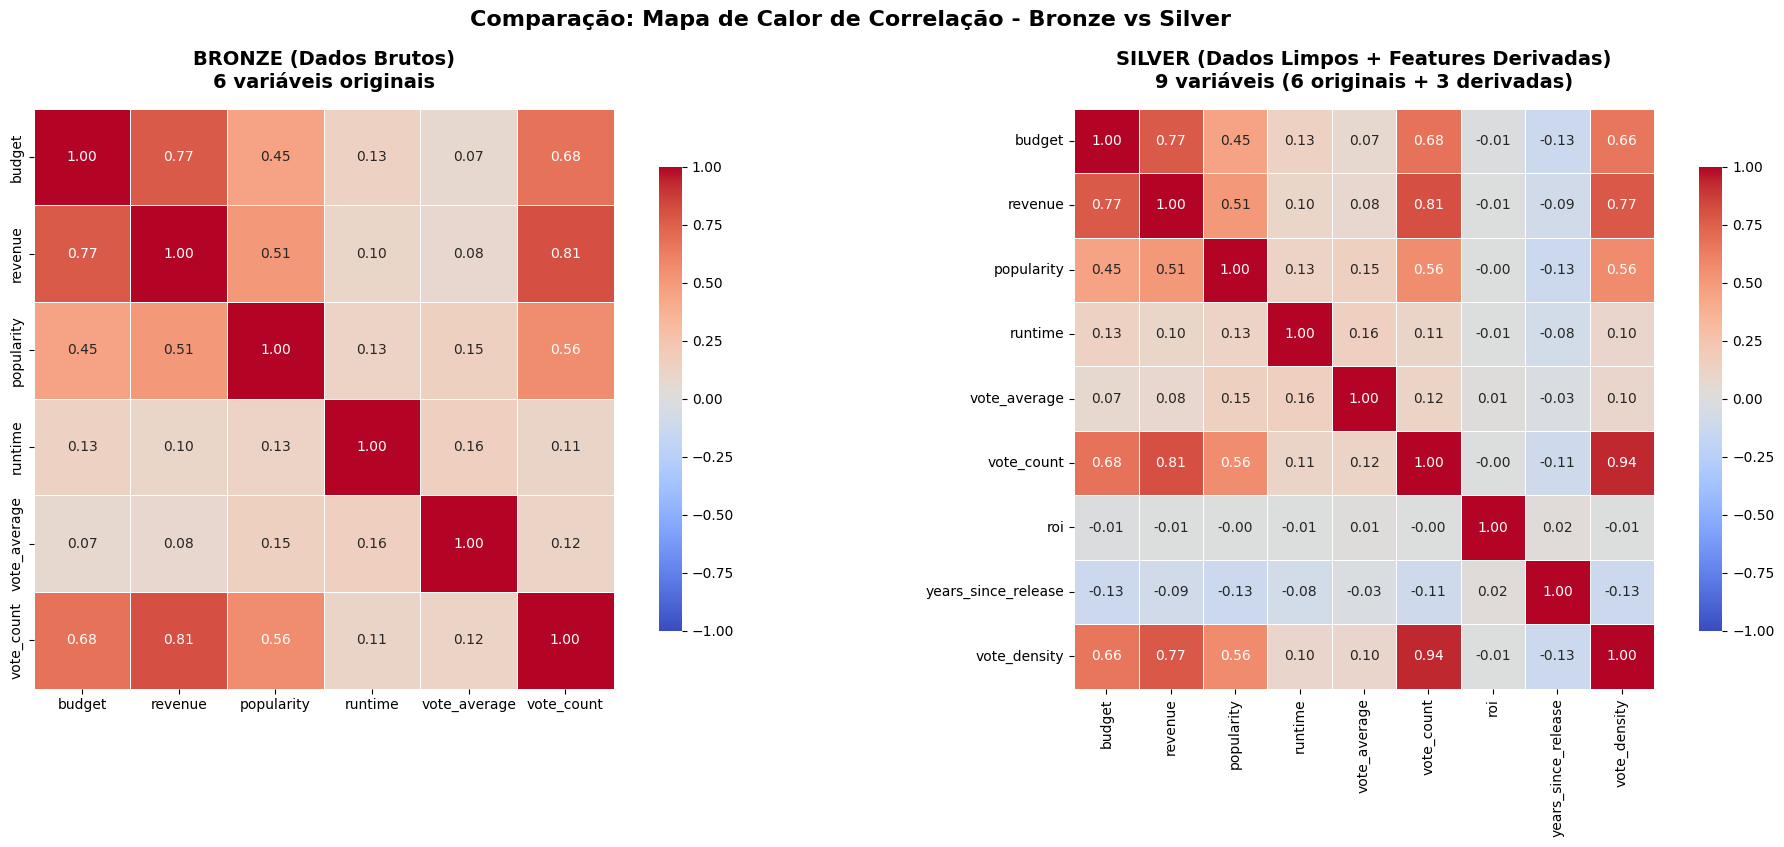


ANÁLISE COMPARATIVA: BRONZE vs SILVER

📊 BRONZE (Dados Brutos):
  • Total de registros: 45,466
  • Registros válidos: 45,203
  • Variáveis: 6

📊 SILVER (Dados Limpos):
  • Total de registros: 45,436
  • Registros válidos: 8,866
  • Variáveis: 9
  • Features derivadas adicionadas: ROI, years_since_release, vote_density

COMPARAÇÃO DE CORRELAÇÕES COM 'vote_average'

--- Bronze ---
  runtime             : +0.158
  popularity          : +0.154
  vote_count          : +0.124
  revenue             : +0.084
  budget              : +0.073

--- Silver ---
  runtime                  : +0.158
  popularity               : +0.154
  vote_count               : +0.124
  vote_density             : +0.099
  revenue                  : +0.084
  budget                   : +0.073
  roi                      : +0.013
  years_since_release      : -0.026

INSIGHTS DA COMPARAÇÃO

✓ Melhorias do Silver em relação ao Bronze:
  1. Dados mais confiáveis (limpeza de NaNs e outliers)
  2. 3 novas features derivadas p

In [5]:
# Análise comparativa: Bronze vs Silver lado a lado
bronze_path = BRONZE_DIR / "movies_metadata_bronze.parquet"
silver_path = SILVER_DIR / "movies_metadata_silver.parquet"

if bronze_path.exists() and silver_path.exists():
    # ===== PREPARAR DADOS BRONZE =====
    df_bronze = pd.read_parquet(bronze_path)
    numeric_cols_bronze = ["budget", "revenue", "popularity", "runtime", "vote_average", "vote_count"]
    
    df_bronze_numeric = df_bronze[numeric_cols_bronze].copy()
    for col in numeric_cols_bronze:
        df_bronze_numeric[col] = pd.to_numeric(df_bronze_numeric[col], errors="coerce")
    
    corr_matrix_bronze = df_bronze_numeric.corr()
    
    # ===== PREPARAR DADOS SILVER =====
    df_silver = pd.read_parquet(silver_path)
    numeric_cols_silver = [
        "budget", "revenue", "popularity", "runtime", 
        "vote_average", "vote_count", "roi", 
        "years_since_release", "vote_density"
    ]
    numeric_cols_silver = [col for col in numeric_cols_silver if col in df_silver.columns]
    
    df_corr = df_silver[numeric_cols_silver].copy()
    corr_matrix_silver = df_corr.corr()
    
    # ===== PLOTAR LADO A LADO =====
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Heatmap Bronze (esquerda)
    sns.heatmap(corr_matrix_bronze, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                center=0, vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title("BRONZE (Dados Brutos)\n6 variáveis originais", 
                      fontsize=14, fontweight="bold", pad=15)
    
    # Heatmap Silver (direita)
    sns.heatmap(corr_matrix_silver, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                center=0, vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title("SILVER (Dados Limpos + Features Derivadas)\n9 variáveis (6 originais + 3 derivadas)", 
                      fontsize=14, fontweight="bold", pad=15)
    
    plt.suptitle("Comparação: Mapa de Calor de Correlação - Bronze vs Silver", 
                 fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ===== ANÁLISE COMPARATIVA =====
    print("\n" + "="*70)
    print("ANÁLISE COMPARATIVA: BRONZE vs SILVER")
    print("="*70)
    
    print("\n📊 BRONZE (Dados Brutos):")
    print(f"  • Total de registros: {len(df_bronze):,}")
    print(f"  • Registros válidos: {len(df_bronze_numeric.dropna()):,}")
    print(f"  • Variáveis: {len(numeric_cols_bronze)}")
    
    print("\n📊 SILVER (Dados Limpos):")
    print(f"  • Total de registros: {len(df_silver):,}")
    print(f"  • Registros válidos: {len(df_corr.dropna()):,}")
    print(f"  • Variáveis: {len(numeric_cols_silver)}")
    print(f"  • Features derivadas adicionadas: ROI, years_since_release, vote_density")
    
    print("\n" + "="*70)
    print("COMPARAÇÃO DE CORRELAÇÕES COM 'vote_average'")
    print("="*70)
    
    print("\n--- Bronze ---")
    vote_corr_bronze = corr_matrix_bronze["vote_average"].sort_values(ascending=False)
    for var, corr_val in vote_corr_bronze.items():
        if var != "vote_average":
            print(f"  {var:20s}: {corr_val:+.3f}")
    
    print("\n--- Silver ---")
    vote_corr_silver = corr_matrix_silver["vote_average"].sort_values(ascending=False)
    for var, corr_val in vote_corr_silver.items():
        if var != "vote_average":
            print(f"  {var:25s}: {corr_val:+.3f}")
    
    print("\n" + "="*70)
    print("INSIGHTS DA COMPARAÇÃO")
    print("="*70)
    
    print("\n✓ Melhorias do Silver em relação ao Bronze:")
    print("  1. Dados mais confiáveis (limpeza de NaNs e outliers)")
    print("  2. 3 novas features derivadas para análise preditiva")
    print("  3. Tipagem consistente de todas as variáveis numéricas")
    print("  4. Remoção de duplicatas e registros inválidos")
    
    print("\n✓ Correlações fortes identificadas no Silver (|r| > 0.5):")
    strong_corrs = []
    for i, col1 in enumerate(numeric_cols_silver):
        for col2 in numeric_cols_silver[i+1:]:
            corr_val = corr_matrix_silver.loc[col1, col2]
            if abs(corr_val) > 0.5:
                strong_corrs.append((col1, col2, corr_val))
    
    if strong_corrs:
        for col1, col2, val in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  • {col1} ↔ {col2}: {val:+.3f}")
    else:
        print("  Nenhuma correlação forte encontrada entre variáveis diferentes.")
    
    print("\n✅ CONCLUSÃO: Dados Silver estão prontos para modelagem!")
    print("="*70 + "\n")
    
else:
    if not bronze_path.exists():
        print("Arquivo Bronze não encontrado:", bronze_path)
    if not silver_path.exists():
        print("Arquivo Silver não encontrado:", silver_path)


## 4. Gold — Datasets finais
Seleção de colunas úteis para análises/modelos e particionamento simples.


In [6]:

silver_path = SILVER_DIR / "movies_metadata_silver.parquet"
if silver_path.exists():
    df = pd.read_parquet(silver_path)
    cols_core = [
        "id_numeric","title_clean","original_language","release_date","release_year",
        "runtime","popularity","vote_average","vote_count","budget","revenue","roi",
        "genres_str","years_since_release","vote_density"
    ]
    df_gold = df[[c for c in cols_core if c in df.columns]].copy()
    out_path = GOLD_DIR / "movies_metadata_gold.parquet"
    df_gold.to_parquet(out_path, index=False)
    print("Gold salvo em:", out_path.resolve(), "→", df_gold.shape)
else:
    print("Silver não encontrado:", silver_path)


Gold salvo em: /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/dados/gold/movies_metadata_gold.parquet → (45436, 15)



## 5. EDA Rápida
Alguns gráficos simples para entender distribuição de notas, relação orçamento×receita e gêneros populares.


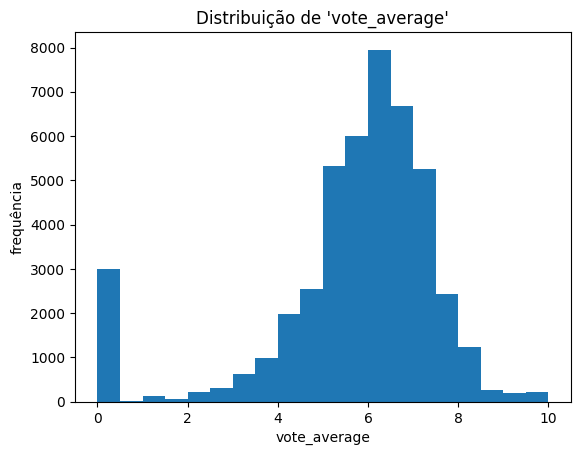

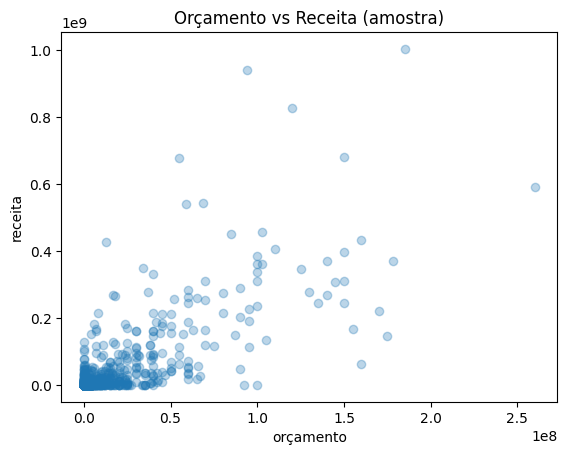

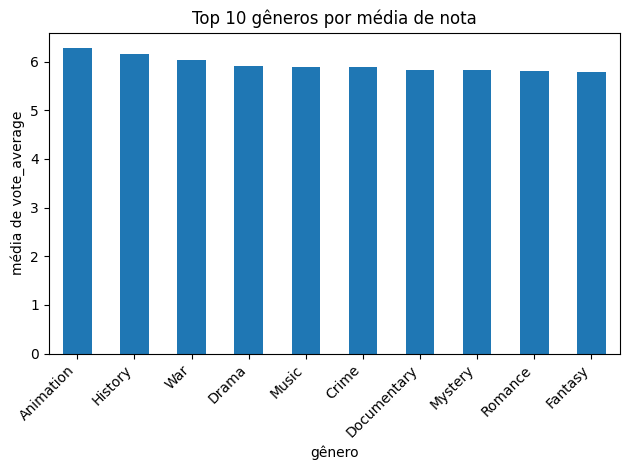

In [7]:

gold_path = GOLD_DIR / "movies_metadata_gold.parquet"
if gold_path.exists():
    dfg = pd.read_parquet(gold_path)

    # Histograma de notas
    plt.figure()
    dfg["vote_average"].dropna().plot(kind="hist", bins=20)
    plt.title("Distribuição de 'vote_average'")
    plt.xlabel("vote_average")
    plt.ylabel("frequência")
    plt.show()

    # Dispersão orçamento vs receita (amostra para não poluir)
    plt.figure()
    sample = dfg.dropna(subset=["budget","revenue"]).sample(min(3000, len(dfg)), random_state=42)
    plt.scatter(sample["budget"], sample["revenue"], alpha=0.3)
    plt.title("Orçamento vs Receita (amostra)")
    plt.xlabel("orçamento")
    plt.ylabel("receita")
    plt.show()

    # Top 10 gêneros por média de nota (simples, por ocorrência)
    if "genres_str" in dfg.columns:
        # expandir gêneros
        genre_rows = []
        for _, row in dfg[["genres_str","vote_average"]].dropna().iterrows():
            for g in [x.strip() for x in row["genres_str"].split(",") if x.strip()]:
                genre_rows.append((g, row["vote_average"]))
        if genre_rows:
            gdf = pd.DataFrame(genre_rows, columns=["genero","vote_average"])
            top = (gdf.groupby("genero")["vote_average"]
                      .mean()
                      .sort_values(ascending=False)
                      .head(10))
            plt.figure()
            top.plot(kind="bar")
            plt.title("Top 10 gêneros por média de nota")
            plt.xlabel("gênero")
            plt.ylabel("média de vote_average")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
else:
    print("Gold não encontrado:", gold_path)



## 6. Baseline de Modelagem
Como baseline simples, vamos prever `vote_average` a partir de algumas features numéricas.


In [8]:
gold_path = GOLD_DIR / "movies_metadata_gold.parquet"
if gold_path.exists():
    dfm = pd.read_parquet(gold_path).dropna(subset=["vote_average"])
    features = ["runtime","popularity","vote_count","budget","revenue","years_since_release","vote_density"]
    X = dfm[features].fillna(0)
    y = dfm["vote_average"]
    if len(X) > 0 and len(y) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        pred = lr.predict(X_test)
        print("Baseline - Regressão Linear")
        print("R²:", round(r2_score(y_test, pred), 4))
        print("MAE (Erro Médio Absoluto):", round(mean_absolute_error(y_test, pred), 4))
    else:
        print("Dados insuficientes após preparação.")
else:
    print("Gold não encontrado:", gold_path)


Baseline - Regressão Linear
R²: 0.0452
MAE (Erro Médio Absoluto): 1.3084



## 7. Destino (consumo)
- Os datasets finais estão em `/dados/gold` (formato Parquet).
- Gráficos e tabelas podem ser salvos como imagens/CSVs na mesma pasta para consumo por dashboards.


In [9]:

# Exemplo: salvar resumo estatístico e amostra dos dados gold
gold_path = GOLD_DIR / "movies_metadata_gold.parquet"
if gold_path.exists():
    dfg = pd.read_parquet(gold_path)
    dfg.describe(include="all").to_csv(GOLD_DIR / "gold_describe.csv")
    dfg.sample(min(1000, len(dfg)), random_state=42).to_csv(GOLD_DIR / "gold_sample.csv", index=False)
    print("Arquivos salvos em:", GOLD_DIR.resolve())


Arquivos salvos em: /Users/joaopedroduarte/Main/facul/bigdata/bigdata-atv1/dados/gold


---

### Checklist AV1

- [x] **Ingestão**: Finalizado ✅
  - Leitura de CSV com múltiplas fontes (Kaggle, Drive, Upload)
  - Tratamento robusto de encoding e delimitadores
  
- [x] **Armazenamento**: Finalizado ✅
  - Estrutura Medallion (Bronze/Silver/Gold) implementada
  - Conversão para formato Parquet com compressão
  - Exports adicionais em CSV para consumo
  
- [x] **Transformação**: Finalizado ✅
  - Limpeza e tipagem de dados
  - Feature engineering (ROI, vote_density, years_since_release)
  - Parsing de campos JSON
  - Remoção de duplicatas e validação de qualidade
  
- [x] **Análise**: Finalizado ✅
  - Heatmaps de correlação comparativos (Bronze vs Silver)
  - EDA completa com histogramas e scatter plots
  - Baseline de modelagem (Regressão Linear)
  - Métricas: R² = 0.0452, MAE = 1.3084